# Noise2Void - 3D Example

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
import random

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

2022-09-29 18:54:30.512636: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [2]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [33]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = []
for i in range(4):
    imgs.extend(datagen.load_imgs_from_directory(directory = f"2022-09-27/block{i+1}", dims='ZYX'))
random.Random(42).shuffle(imgs)
imgs = imgs[::20]
# Let's look at the shape of the image
print(imgs[0].shape)
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

(1, 20, 512, 512, 1)


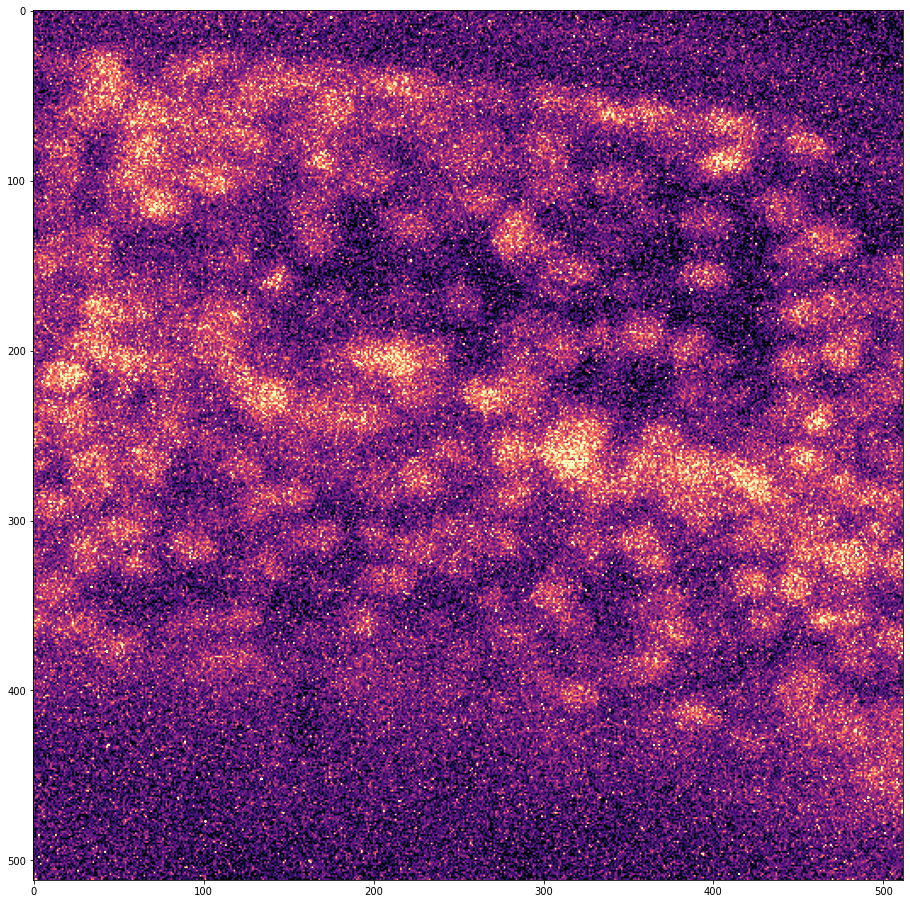

In [34]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

In [35]:
# Here we extract patches for training and validation.
patch_shape = (8, 64, 64)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)
Generated patches: (1024, 8, 64, 64, 1)


In [36]:
len(patches)

60416

In [37]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:int(len(patches) * 0.7)]
X_val = patches[int(len(patches) * 0.7):]
print(f'training data: {len(X)}')
print(f'validation data: {len(X_val)}')

training data: 42291
validation data: 18125


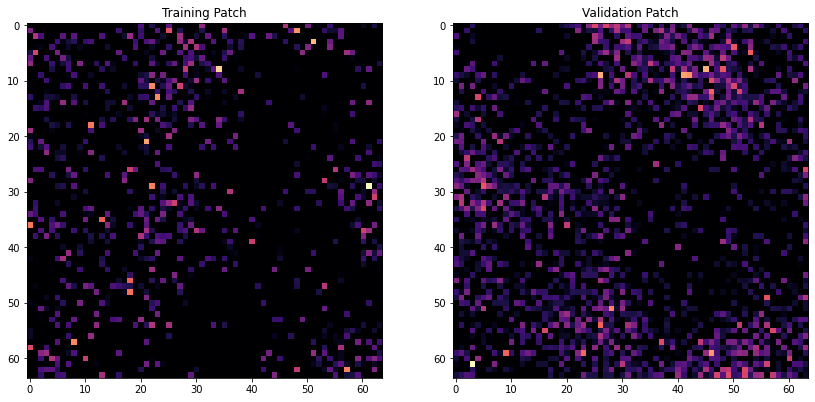

In [38]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,4,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,4,...,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [39]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(8, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['3.0410216'],
 'stds': ['7.2873783'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 330,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (8, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [40]:
# a name used to identify the model
model_name = 'n2v_3D_20220927_blockwise2'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

## Training

In [41]:
history = model.train(X, X_val)

64 blind-spots will be generated per training patch of size (8, 64, 64).



Preparing validation data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18125/18125 [00:06<00:00, 2723.35it/s]


Epoch 1/20
330/330 [==============================] - 52s 153ms/step - loss: 1.1721 - n2v_mse: 1.1721 - n2v_abs: 0.6390 - val_loss: 0.9752 - val_n2v_mse: 0.9750 - val_n2v_abs: 0.5433 - lr: 4.0000e-04
Epoch 2/20
330/330 [==============================] - 44s 133ms/step - loss: 0.9397 - n2v_mse: 0.9397 - n2v_abs: 0.5760 - val_loss: 0.9642 - val_n2v_mse: 0.9641 - val_n2v_abs: 0.5475 - lr: 4.0000e-04
Epoch 3/20
330/330 [==============================] - 45s 136ms/step - loss: 0.9357 - n2v_mse: 0.9357 - n2v_abs: 0.5905 - val_loss: 1.0204 - val_n2v_mse: 1.0202 - val_n2v_abs: 0.6642 - lr: 4.0000e-04
Epoch 4/20
330/330 [==============================] - 44s 134ms/step - loss: 0.8059 - n2v_mse: 0.8059 - n2v_abs: 0.5672 - val_loss: 0.9366 - val_n2v_mse: 0.9365 - val_n2v_abs: 0.5606 - lr: 4.0000e-04
Epoch 5/20
330/330 [==============================] - 44s 132ms/step - loss: 0.8425 - n2v_mse: 0.8425 - n2v_abs: 0.5502 - val_loss: 0.9549 - val_n2v_mse: 0.9547 - val_n2v_abs: 0.5744 - lr: 4.0000e-04


### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


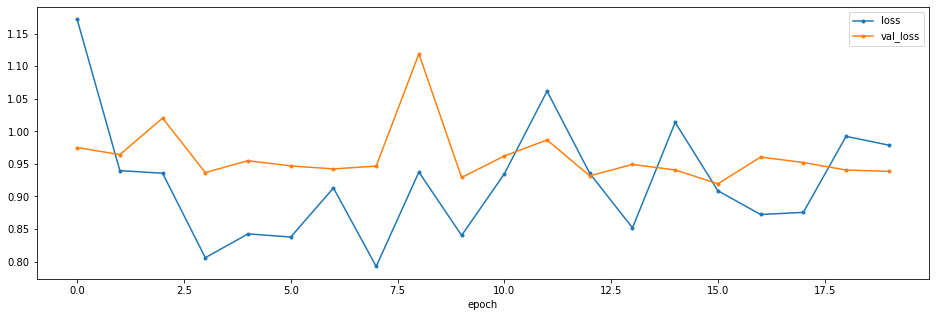

In [42]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [23]:
model.export_TF(name='Noise2Void - 3D Parhyale', 
                description='This is the 3D Noise2Void model for Parhyale confocal data.', 
                authors=["Ko Sugawara"],
                test_img=X_val[0,...,0], axes='ZYX',
                patch_shape=patch_shape)

1/1 [==============================] - 0s 438ms/step
Instructions for updating:
Colocations handled automatically by placer.


2022-07-19 18:19:31.583108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46715 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-07-19 18:19:31.584978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46665 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2022-07-19 18:19:31.633879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


/mnt/md0/applications/miniconda3/envs/n2v/lib/python3.7/site-packages/csbdeep/utils/tf.py:189: UserWarning: 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

  """)


INFO:tensorflow:/tmp/tmpa5pw4of1/model/variables/variables.data-00000-of-00001
INFO:tensorflow:3400
INFO:tensorflow:/tmp/tmpa5pw4of1/model/variables/variables.index
INFO:tensorflow:3400
INFO:tensorflow:SavedModel written to: /tmp/tmpa5pw4of1/model/saved_model.pb

Model exported in BioImage ModelZoo format:
/mnt/md0/repositories/n2v/examples/3D/models/n2v_3D/export.bioimage.io.zip


In [19]:
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
from pathlib import Path

In [17]:
model = N2V(config=config, name=model_name, basedir=basedir)

/mnt/md0/applications/miniconda3/envs/n2v/lib/python3.7/site-packages/n2v/models/n2v_standard.py:428: UserWarning: output path for model already exists, files may be overwritten: /mnt/md0/repositories/n2v/examples/3D/models/n2v_3D_20220927_blockwise
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [43]:
datadir = '2022-09-27'
preddir = 'pred_postavg_' + datadir
Path(preddir).mkdir(exist_ok=True)
for t in range(1):
    blocks = []
    for i in range(4):
        img = imread(f'{datadir}/block{i+1}/t{t:03d}.tif')
        pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))
        blocks.append(pred)
    avg = np.mean(blocks, axis=0)
    avg -= avg.min()
    avg = (avg / avg.max() * 255).astype(np.uint8)
    save_tiff_imagej_compatible(f'{preddir}/t{t:03d}.tif', avg, 'ZYX')

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 1s 582ms/step



  6%|██████████▎                                                                                                                                                          | 1/16 [00:00<00:00, 1155.77it/s]

1/1 [==============================] - 0s 42ms/step



 12%|████████████████████▉                                                                                                                                                  | 2/16 [00:00<00:00, 16.34it/s]

1/1 [==============================] - 0s 44ms/step



 19%|███████████████████████████████▎                                                                                                                                       | 3/16 [00:00<00:00, 16.34it/s]

1/1 [==============================] - 0s 43ms/step



 25%|█████████████████████████████████████████▊                                                                                                                             | 4/16 [00:00<00:01, 10.04it/s]

1/1 [==============================] - 0s 40ms/step



 31%|████████████████████████████████████████████████████▏                                                                                                                  | 5/16 [00:00<00:01, 10.04it/s]

1/1 [==============================] - 0s 37ms/step



 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 6/16 [00:01<00:01,  5.10it/s]

1/1 [==============================] - 0s 54ms/step



 44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 7/16 [00:01<00:01,  5.52it/s]

1/1 [==============================] - 0s 43ms/step



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 8/16 [00:01<00:01,  6.03it/s]

1/1 [==============================] - 0s 45ms/step



 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 9/16 [00:01<00:01,  6.33it/s]

1/1 [==============================] - 0s 44ms/step



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 10/16 [00:01<00:00,  6.67it/s]

1/1 [==============================] - 0s 43ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 11/16 [00:01<00:00,  6.96it/s]

1/1 [==============================] - 0s 43ms/step



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 12/16 [00:01<00:00,  7.18it/s]

1/1 [==============================] - 0s 43ms/step



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 13/16 [00:01<00:00,  7.34it/s]

1/1 [==============================] - 0s 44ms/step



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 14/16 [00:02<00:00,  7.45it/s]

1/1 [==============================] - 0s 44ms/step



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:02<00:00,  7.56it/s]

1/1 [==============================] - 0s 43ms/step



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.88it/s]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 41ms/step



  6%|██████████▎                                                                                                                                                          | 1/16 [00:00<00:00, 1016.80it/s]

1/1 [==============================] - 0s 44ms/step



 12%|████████████████████▉                                                                                                                                                  | 2/16 [00:00<00:00, 15.90it/s]

1/1 [==============================] - 0s 39ms/step



 19%|███████████████████████████████▎                                                                                                                                       | 3/16 [00:00<00:00, 15.90it/s]

1/1 [==============================] - 0s 40ms/step



 25%|█████████████████████████████████████████▊                                                                                                                             | 4/16 [00:00<00:01, 10.32it/s]

1/1 [==============================] - 0s 40ms/step



 31%|████████████████████████████████████████████████████▏                                                                                                                  | 5/16 [00:00<00:01, 10.32it/s]

1/1 [==============================] - 0s 39ms/step



 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 6/16 [00:00<00:01,  9.19it/s]

1/1 [==============================] - 0s 40ms/step



 44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 7/16 [00:00<00:01,  8.93it/s]

1/1 [==============================] - 0s 40ms/step



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 8/16 [00:00<00:00,  8.74it/s]

1/1 [==============================] - 0s 39ms/step



 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 9/16 [00:01<00:00,  8.26it/s]

1/1 [==============================] - 0s 40ms/step



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 10/16 [00:01<00:00,  8.05it/s]

1/1 [==============================] - 0s 43ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 11/16 [00:01<00:00,  7.98it/s]

1/1 [==============================] - 0s 41ms/step



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 12/16 [00:01<00:00,  8.04it/s]

1/1 [==============================] - 0s 39ms/step



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 13/16 [00:01<00:00,  8.02it/s]

1/1 [==============================] - 0s 40ms/step



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 14/16 [00:01<00:00,  8.06it/s]

1/1 [==============================] - 0s 42ms/step



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:01<00:00,  8.00it/s]

1/1 [==============================] - 0s 44ms/step



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.41it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 40ms/step



  6%|██████████▎                                                                                                                                                          | 1/16 [00:00<00:00, 1020.51it/s]

1/1 [==============================] - 0s 43ms/step



 12%|████████████████████▉                                                                                                                                                  | 2/16 [00:00<00:00, 15.90it/s]

1/1 [==============================] - 0s 40ms/step



 19%|███████████████████████████████▎                                                                                                                                       | 3/16 [00:00<00:00, 15.90it/s]

1/1 [==============================] - 0s 42ms/step



 25%|█████████████████████████████████████████▊                                                                                                                             | 4/16 [00:00<00:01,  9.84it/s]

1/1 [==============================] - 0s 43ms/step



 31%|████████████████████████████████████████████████████▏                                                                                                                  | 5/16 [00:00<00:01,  9.84it/s]

1/1 [==============================] - 0s 44ms/step



 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 6/16 [00:00<00:01,  8.71it/s]

1/1 [==============================] - 0s 42ms/step



 44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 7/16 [00:00<00:01,  8.45it/s]

1/1 [==============================] - 0s 41ms/step



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 8/16 [00:00<00:00,  8.32it/s]

1/1 [==============================] - 0s 42ms/step



 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 9/16 [00:01<00:00,  8.06it/s]

1/1 [==============================] - 0s 42ms/step



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 10/16 [00:01<00:00,  7.96it/s]

1/1 [==============================] - 0s 42ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 11/16 [00:01<00:00,  7.90it/s]

1/1 [==============================] - 0s 42ms/step



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 12/16 [00:01<00:00,  7.90it/s]

1/1 [==============================] - 0s 41ms/step



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 13/16 [00:01<00:00,  7.63it/s]

1/1 [==============================] - 0s 50ms/step



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 14/16 [00:01<00:00,  7.59it/s]

1/1 [==============================] - 0s 43ms/step



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:01<00:00,  7.67it/s]

1/1 [==============================] - 0s 42ms/step



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]

The input image is of type uint8 and will be casted to float32 for prediction.


1/1 [==============================] - 0s 39ms/step



  6%|██████████▎                                                                                                                                                          | 1/16 [00:00<00:00, 1172.90it/s]

1/1 [==============================] - 0s 42ms/step



 12%|████████████████████▉                                                                                                                                                  | 2/16 [00:00<00:00, 16.07it/s]

1/1 [==============================] - 0s 41ms/step



 19%|███████████████████████████████▎                                                                                                                                       | 3/16 [00:00<00:00, 16.07it/s]

1/1 [==============================] - 0s 43ms/step



 25%|█████████████████████████████████████████▊                                                                                                                             | 4/16 [00:00<00:01, 10.09it/s]

1/1 [==============================] - 0s 41ms/step



 31%|████████████████████████████████████████████████████▏                                                                                                                  | 5/16 [00:00<00:01, 10.09it/s]

1/1 [==============================] - 0s 42ms/step



 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 6/16 [00:00<00:01,  8.66it/s]

1/1 [==============================] - 0s 42ms/step



 44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 7/16 [00:00<00:01,  8.43it/s]

1/1 [==============================] - 0s 43ms/step



 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 8/16 [00:00<00:00,  8.24it/s]

1/1 [==============================] - 0s 43ms/step



 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 9/16 [00:01<00:00,  8.00it/s]

1/1 [==============================] - 0s 40ms/step



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 10/16 [00:01<00:00,  7.97it/s]

1/1 [==============================] - 0s 39ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 11/16 [00:01<00:00,  7.79it/s]

1/1 [==============================] - 0s 42ms/step



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 12/16 [00:01<00:00,  7.78it/s]

1/1 [==============================] - 0s 39ms/step



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 13/16 [00:01<00:00,  7.82it/s]

1/1 [==============================] - 0s 40ms/step



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 14/16 [00:01<00:00,  7.89it/s]

1/1 [==============================] - 0s 42ms/step



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 15/16 [00:01<00:00,  7.91it/s]

1/1 [==============================] - 0s 39ms/step



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]
